<a href="https://colab.research.google.com/github/mmosoriov/proj5_DL/blob/ML_part1_Mateo/Part1_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: Miguel Mateo Osorio Vela, Matthew West

Development environment: Colab

# Part 1, ML: Baseline, PCA, Logistic Regression

- Task:
  - Come up with and implement a baseline for this task
    - Consider what technqiues we've covered in class might be relevant. Or come up with something all on your own.
    - Include a description of your baseline to accompany the implementation and explain why this baseline makes sense for this problem.
  - Compare the performance of your simple baseline with two of the following of your choice: PCA and Logistic Regression. Compare their performance on the Olivetti faces dataset on different evaluation scenarios
  - *If hyperparameters need to be selected, pull out a reasonable held-out set from the training set and performance hyperparameter selection.


- Evaluation scenarios:
  - Use 30% of the images for training and 70% for testing
  - Use 60% of the images for training and 40% for testing
  - Use 90% of the images for training and 10% for testing
  - Always use the first K images per person for training, and the remaining ones for testing (see data split code below)
  - Choose an evaluation method: CMC curve or confusion matrix. Run this for each combination of scenario and method.


- Discussion:
  - If you used a held-out set, how did you choose your method of held-out set selection method? If not, why was it not necessary?
    - What effect did your choice have on your final results?
  - Is there a clear difference in performance for different approaches?
  - Is there a clear difference in performance for different train/test data splits?

## Olivetti faces dataset (AT&T Laboratories Cambridge)

As described on the original website:

"*There are ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement).*"

The original dataset consisted of 92 x 112, while the version available here consists of 64x64 images.

- Classes: 40
- Samples per class: 10
- Samples total: 400
- Dimensionality: 4096 (64x64 pixels)
- Pixel values: real, between 0 and 1


In [1]:
from sklearn.datasets import fetch_olivetti_faces
from google.colab.patches import cv2_imshow
import numpy as np

# Get the dataset

In [2]:
faces = fetch_olivetti_faces()

_, img_height, img_width = faces.images.shape

print(faces.images.shape)

(400, 64, 64)


# Split the dataset

In [3]:
N_IDENTITIES = len(np.unique(faces.target)) # how many different individuals are in the dataset
GALLERY_SIZE = 5                            # use the first GALLERY_SIZE images per individual for training, the rest for testing

gallery_indices = []
probe_indices = []
for i in range(N_IDENTITIES):
  indices = list(np.where(faces.target == i)[0])
  gallery_indices += indices[:GALLERY_SIZE]
  probe_indices += indices[GALLERY_SIZE:]

x_train = faces.images[gallery_indices].reshape(-1, img_height*img_width) # vectorize train images
y_train = faces.target[gallery_indices]
x_test = faces.images[probe_indices].reshape(-1, img_height*img_width)    # vectorize test images
y_test = faces.target[probe_indices]

print(x_train.shape, x_test.shape)

(200, 4096) (200, 4096)


# Visualize the splits

In [4]:
def show_images(imgs, num_rows, num_cols):
  assert len(imgs) == num_rows*num_cols

  for i in range(num_rows):
    row = None
    for j in range(num_cols):
      if row is None:
        row = imgs[i*num_cols+j].reshape(img_height, img_width)*255.0
      else:
        row = np.concatenate((row, imgs[i*num_cols+j].reshape(img_height, img_width)*255.0), axis=1)
    cv2_imshow(row)

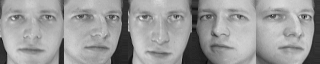

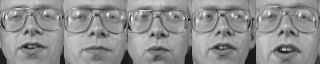

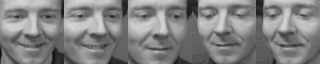

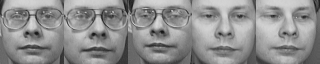

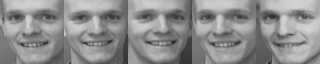

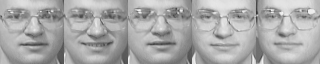

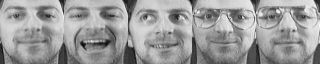

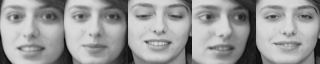

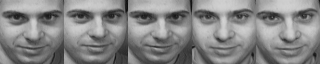

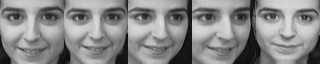

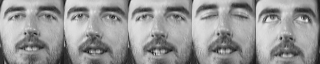

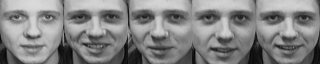

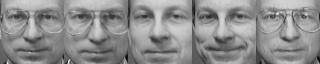

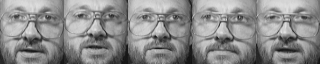

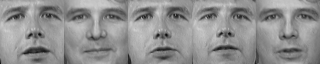

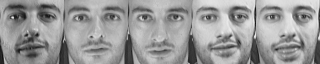

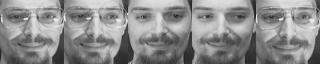

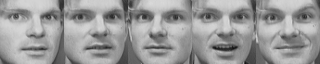

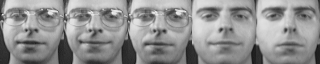

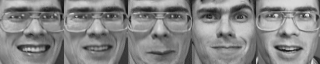

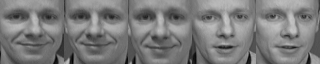

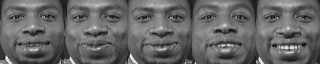

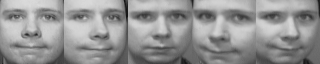

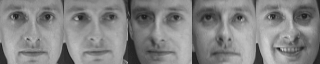

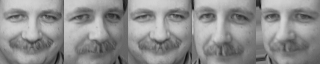

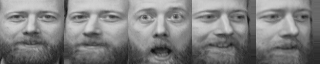

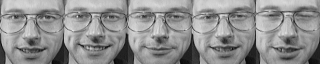

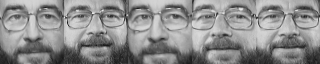

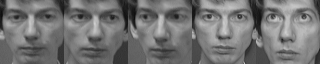

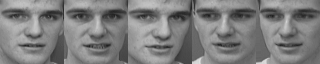

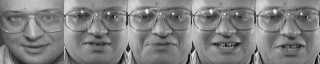

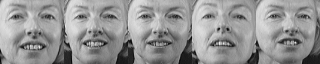

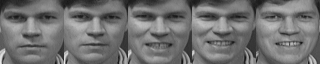

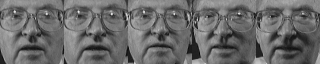

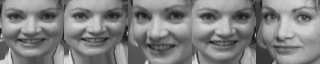

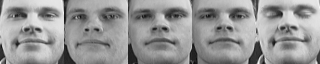

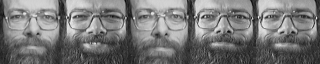

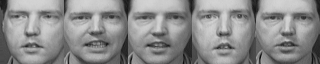

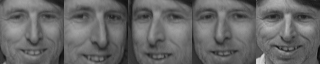

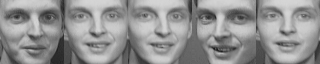

In [5]:
show_images(x_train, N_IDENTITIES, GALLERY_SIZE)

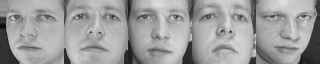

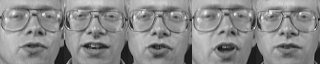

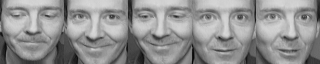

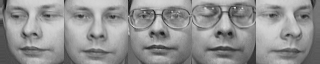

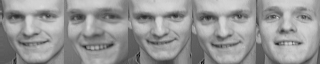

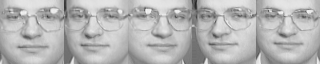

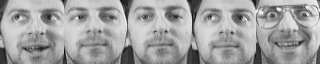

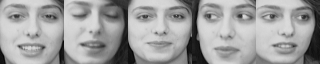

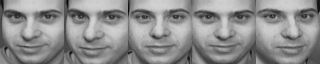

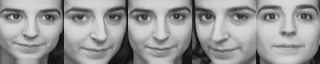

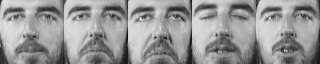

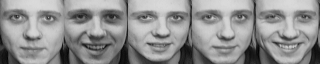

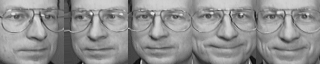

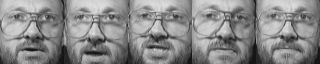

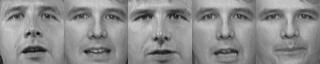

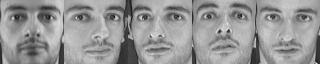

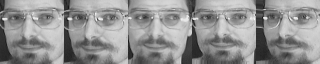

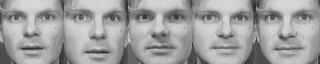

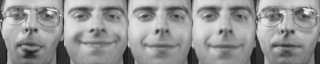

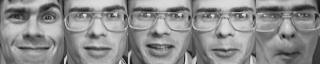

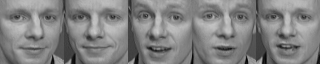

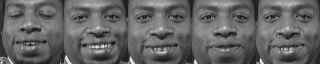

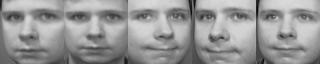

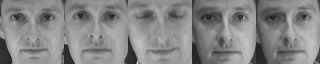

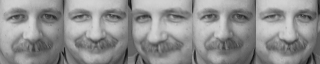

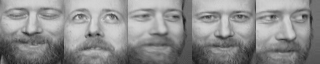

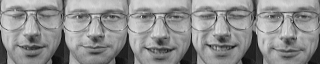

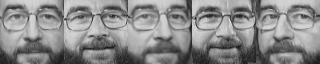

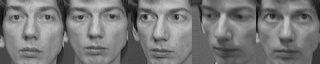

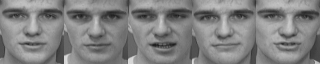

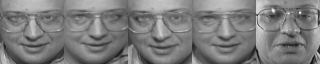

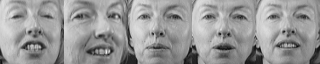

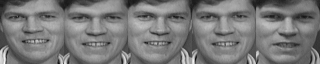

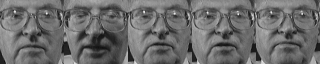

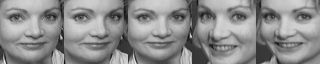

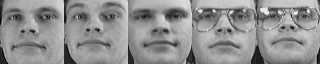

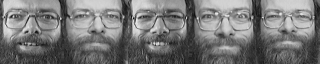

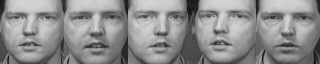

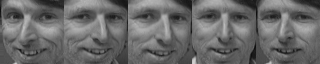

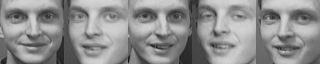

In [6]:
show_images(x_test, N_IDENTITIES, 10 - GALLERY_SIZE)

# Implement your baseline

Here is the code for my baseline, along with an explanation of how it works and why it makes sense for this problem.

In [7]:
"""
DATA setup
"""
import numpy as np
import matplotlib.pyplot as plt # for plotting results
from sklearn.datasets import fetch_olivetti_faces
from sklearn.preprocessing import Binarizer # maps continous values -> 0 or 1
from sklearn.naive_bayes import BernoulliNB # Bernoulli(0 or 1) classifier in baseline
from sklearn.metrics import accuracy_score # to calculate how many predictions were correct

from sklearn.model_selection import train_test_split # used in PCA to create small held-out set to tune number eigenfaces

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier # K-nearest neighbors classifier
from sklearn.linear_model import LogisticRegression


print("Loading Olivetti Faces dataset....")
images = fetch_olivetti_faces()
X_full = images.data  # By documentation: shape of (400, 4096) => 400 images, 64x64 pixels flattened
y_full = images.target # Shape of (400,) => Labels associated with each image 0-39 // THE ANSWERS


# Reshape to (40 people, 10 images, 4096 pixels) to organize data by person
X_by_person = X_full.reshape(40, 10, 4096) # this forms a 3d block, which allows us to later say X_by_personl[0, :3] to retrieve the first 3 images of person 0
# Reshape to match structure above
y_by_person = y_full.reshape(40, 10)

Loading Olivetti Faces dataset....


In [8]:
"""
MODEL DEFINITIONS

"""

"""
BASELINE: Naive Bayes(Bernoulli, 0 or 1)
Logic: Feature values for each pixel are black or white depending if the intensity is > or < than 0.5
This is a simple and efficient way to generate an acceptable baseline that ignores noise.
It has the downside that we loose some "texture" data by categorizing everything as black or white.
"""

def run_baseline_naive_bayes(X_train, y_train, X_test, y_test):

    # Turn grayscale into 0 or 1
    to_binary = Binarizer(threshold=0.5)
    X_train_bin = to_binary.transform(X_train)
    X_test_bin = to_binary.transform(X_test)

    Naive_Bayes_model = BernoulliNB() # initializes model which assumes pixels are independent

    # Training: counts how often each pixel for person X is black/white
    Naive_Bayes_model.fit(X_train_bin, y_train)

    # Test model
    y_pred = Naive_Bayes_model.predict(X_test_bin)

    return accuracy_score(y_test, y_pred) #returns fraction of correctly classified samples

def run_pca_eigenfaces(X_train, y_train, X_test, y_test):
    """
    PCA (Eigenfaces) Approach:
    Reduces dimensions -> 1-Nearest Neighbor Classifier.
    Includes internal validation to pick best n_components.
    """
    # Check if we have enough data to split for validation
    # We need the validation set to be at least as large as the number of classes (40)
    # 20% split means total samples must be >= 200 for stratification to work guaranteed

    n_samples = len(X_train)
    n_classes = len(np.unique(y_train))

    # Default best_n if we can't validte
    best_n = min(n_samples, 50)

    # Only perform Grid Search if we have enough data to split safely
    # (Validation set size > n_classes)
    if n_samples * 0.2 >= n_classes:
        X_tr_sub, X_val, y_tr_sub, y_val = train_test_split(
            X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
        )

        best_acc = -1

        component_options = [20, 50, 80, 120]
        for n in component_options:
            if n > len(X_tr_sub): continue

            pca = PCA(n_components=n, whiten=True, random_state=42)
            X_tr_pca = pca.fit_transform(X_tr_sub)
            X_val_pca = pca.transform(X_val)

            knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
            knn.fit(X_tr_pca, y_tr_sub)
            acc = knn.score(X_val_pca, y_val)

            if acc > best_acc:
                best_acc = acc
                best_n = n
    else:
        # If data is too small (e.g. k=2 case), stratify will fail.
        # We just use a heuristic: usually ~20-40 components is good for small data.
        # We cap it at n_samples because PCA can't have components > samples
        best_n = min(40, n_samples)

    # Refit on FULL training set with the chosen parameter
    final_pca = PCA(n_components=best_n, whiten=True, random_state=42)
    X_train_pca = final_pca.fit_transform(X_train)
    X_test_pca = final_pca.transform(X_test)

    final_knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
    final_knn.fit(X_train_pca, y_train)
    y_pred = final_knn.predict(X_test_pca)

    return accuracy_score(y_test, y_pred)

def run_logistic_regression(X_train, y_train, X_test, y_test):
    """
    Logistic Regression Approach:
    Linear classifier on RAW pixels (4096 dimensions).
    """
    # Using 'saga' solver because it handles large datasets/features well
    # C=1.0 is standard regularization
    clf = LogisticRegression(solver='saga', max_iter=200, C=1e-2, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    return accuracy_score(y_test, y_pred)

# Run the experiments

Here is the code I used to get the results below!

In [9]:
# ==========================================
# 3. EXPERIMENT LOOP
# ==========================================
# Scenarios: How many images per person do we use for training?
# k=2 (20% Train), k=5 (50% Train), k=8 (80% Train)
train_sizes = [2, 5, 8]

results = {
    'train_k': [],
    'Baseline (NB)': [],
    'PCA (Eigenfaces)': [],
    'Logistic Regression': []
}

print(f"{'Images/Person':<15} | {'Baseline (NB)':<15} | {'PCA (1-NN)':<15} | {'LogReg (Raw)':<15}")
print("-" * 70)

for k in train_sizes:
    # Construct the split manually to ensure exactly k images per person
    X_train_list, y_train_list = [], []
    X_test_list, y_test_list = [], []

    for p_id in range(40):
        # Taking first k for train, rest for test
        X_train_list.append(X_by_person[p_id, :k, :])
        y_train_list.append(y_by_person[p_id, :k])
        X_test_list.append(X_by_person[p_id, k:, :])
        y_test_list.append(y_by_person[p_id, k:])

    X_train = np.vstack(X_train_list)
    y_train = np.concatenate(y_train_list)
    X_test = np.vstack(X_test_list)
    y_test = np.concatenate(y_test_list)

    # Run Models
    acc_nb = run_baseline_naive_bayes(X_train, y_train, X_test, y_test)
    acc_pca = run_pca_eigenfaces(X_train, y_train, X_test, y_test)
    acc_lr = run_logistic_regression(X_train, y_train, X_test, y_test)

    # Store Results
    results['train_k'].append(k)
    results['Baseline (NB)'].append(acc_nb)
    results['PCA (Eigenfaces)'].append(acc_pca)
    results['Logistic Regression'].append(acc_lr)

    print(f"{k:<15} | {acc_nb:.4f}          | {acc_pca:.4f}          | {acc_lr:.4f}")

Images/Person   | Baseline (NB)   | PCA (1-NN)      | LogReg (Raw)   
----------------------------------------------------------------------
2               | 0.5875          | 0.7188          | 0.5594
5               | 0.6500          | 0.8650          | 0.7750
8               | 0.7625          | 0.9000          | 0.8250


# Report your results

Check these amazing plots I have below!

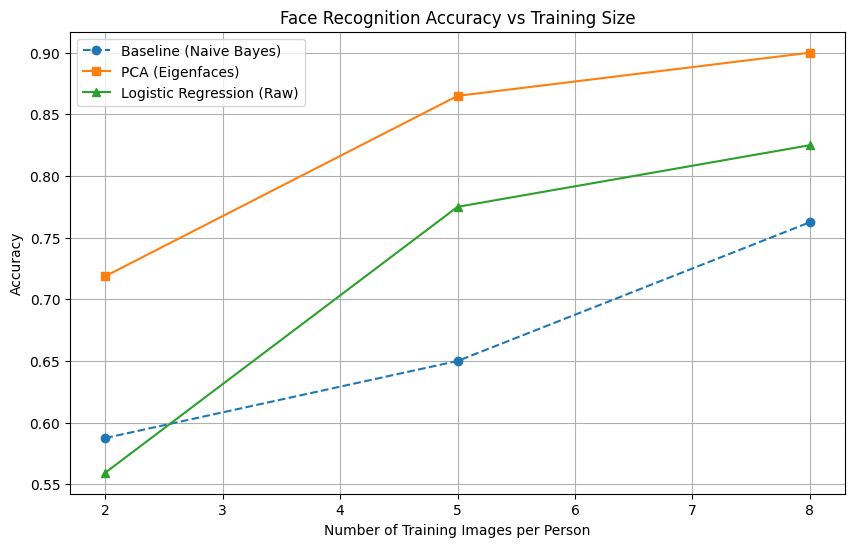

In [10]:
# ==========================================
# 4. PLOTTING RESULTS
# ==========================================
plt.figure(figsize=(10, 6))
plt.plot(results['train_k'], results['Baseline (NB)'], marker='o', linestyle='--', label='Baseline (Naive Bayes)')
plt.plot(results['train_k'], results['PCA (Eigenfaces)'], marker='s', label='PCA (Eigenfaces)')
plt.plot(results['train_k'], results['Logistic Regression'], marker='^', label='Logistic Regression (Raw)')

plt.title('Face Recognition Accuracy vs Training Size')
plt.xlabel('Number of Training Images per Person')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Part 2, DL: CNN and RNN

- **Tasks:**
  1. Compare the performance of a small CNN (LeNet-5) with the results you got from the last project using the Olivetti faces dataset (PCA and Logistic Regression)
  2. Choose, implement (if not available in a library), and run a baseline for the IMDB text classification from lecture
    - Consider what techniques would be appropriate for this task.
    - Also consider the fact that this is a text dataset, so some techniques might not work well or may be cumbersome to engineer.
    - Include a description of your baseline and explain why this baseline makes sense for this problem.
  3. Run a vanilla RNN on the IMDB text classification dataset and compare its performance against your baseline.

_Where it is relevant, make sure you follow deep learning best practices discussed in class. In particular, performing a hyperparameter search and setting up an proper train, dev, and test framework for evaluating hyperparameters and your final selected model._

- Evaluation scenarios:
  1. Facial Recognition
    - Use 20% of the images for training and 80% for testing
    - Use 50% of the images for training and 50% for testing
    - Use 80% of the images for training and 20% for testing
    - Always use the first K images per person for training, and the remaining ones for testing (see data split code below)
    - Plot CMC curve and confusion matrix for each combination of scenario

  2. Review Text Classification
    - Use 2,000 examples for training and 2,000 examples for testing (smaller than the example in lecture)
    - Experiment with several RNN configurations
    - Plot the training and validation plots for your RNN and for your baseline if your baseline has a training phase.
    - Plot a confusion matrix of the predictions.

- Discussion:
  1. Facial Recognition
    - Is LeNet-5 better than PCA/LDA/SVM?
    - Is there a clear difference in performance for different train/test data splits?
    - Does data augmentation improve the results?
  
  2. Review Text Classification
    - Is the vanilla RNN better than a simple baseline?
    - How sensitive is the RNN performance to hyperparameter selection?
    - Does data augmentation improve the results? More or less than for the facial recognition task? What properties of the two tasks do you think is leading to the data augmentation effects you are seeing?


# Run the facial recognition experiments

Here is the code I used to get the results below!

# Report your results

Check these amazing plots I have below!

# IMDB Movie Review Dataset
Description from https://www.tensorflow.org/datasets/catalog/imdb_reviews:
> Large Movie Review Dataset. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.

In [11]:
import tensorflow_datasets
import numpy as np

Load dataset

In [12]:
dataset, info = tensorflow_datasets.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Get subset of the data for training and testing (2000 samples each). Convert Keras dataset to lists of strings and labels.

In [13]:
x_train = []
y_train = []

for sample, label in train_dataset.take(2000):
  x_train.append(sample.numpy())
  y_train.append(label.numpy())

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

print(x_train[0])
print(y_train[0])

x_test = []
y_test = []

for sample, label in test_dataset.take(2000):
  x_test.append(sample.numpy())
  y_test.append(label.numpy())

x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

print(x_test[0])
print(y_test[0])

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
0
b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of th

# Add your baseline

Here is the code for my baseline, along with an explanation of how it works and why it makes sense for this problem.

# Run the experiments

Here is the code I used to get the results below!

# Report your results

Check these amazing plots I have below!

# Extra Credit (10 points)

Explore data augmentation techniques for both tasks.
* (3 points) For the image task, you may use the built-in Keras data augmentation function (tf.keras.preprocessing.image.ImageDataGenerator).
* (5 points) For the text task, you may find an external function that you import or write your own data augmentation.
* (2 points) Describe what data augmentation methods you used and the motivation behind them (why you thought they would help).
